# The e2e Model Lifecycle on SAS Viya Platform

In this notebook, 

1. Build and train the model.
2. Create an API of the model. (Here we have put it in a flask API).
3. Create the requirements file containing all the required libraries.
4. Create the docker file with necessary environment setup and start-up operations.
5. Build the docker image.

I train XGboost model for testing Docker Private ML environment

## Libraries

In [1]:
# Mongo Library

import pymongo

# ML libraries 

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import statsmodels.api as smodel
from xgboost import XGBClassifier 

# Tool libraries

# import json
import os
# import requests as req
# import random
# import pickle
# import zipfile
# import urllib
# import base64
# import time
# import sys

# import sasctl

## Data Engineering

### Load Data from Mongo

In [2]:
#Connect to mongodb container

conn = pymongo.MongoClient('mongo', 27017)

In [3]:
conn

MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True)

In [4]:
db = conn.training
collection = db.churn_data

In [5]:
df = pd.DataFrame(list(collection.find()))
df.drop('_id', axis=1, inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.3667,1,9,
1,1,1300,70053,68400,HomeImp,Other,7,0,2,121.833,0,14,
2,1,1500,13500,16700,HomeImp,Other,4,0,0,149.467,1,10,
3,1,1500,,,,,,,,,,,
4,0,1700,97800,112000,HomeImp,Office,3,0,0,93.3333,0,14,


### Declare data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101320 entries, 0 to 101319
Data columns (total 13 columns):
BAD        101320 non-null int64
LOAN       101320 non-null int64
MORTDUE    101320 non-null object
VALUE      101320 non-null object
REASON     101320 non-null object
JOB        101320 non-null object
YOJ        101320 non-null object
DEROG      101320 non-null object
DELINQ     101320 non-null object
CLAGE      101320 non-null object
NINQ       101320 non-null object
CLNO       101320 non-null object
DEBTINC    101320 non-null object
dtypes: int64(2), object(11)
memory usage: 10.0+ MB


In [7]:
cols = df[df.columns.difference(['BAD','LOAN','REASON','JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD']=df['BAD'].astype('category')

In [8]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333336,0.0,14.0,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101320 entries, 0 to 101319
Data columns (total 13 columns):
BAD        101320 non-null category
LOAN       101320 non-null int64
MORTDUE    92514 non-null float32
VALUE      99416 non-null float32
REASON     101320 non-null object
JOB        101320 non-null object
YOJ        92565 non-null float32
DEROG      89284 non-null float32
DELINQ     91460 non-null float32
CLAGE      96084 non-null float32
NINQ       92650 non-null float32
CLNO       97546 non-null float32
DEBTINC    79781 non-null float32
dtypes: category(1), float32(9), int64(1), object(2)
memory usage: 5.9+ MB


### Declare variables 

In [10]:
#target var
target = df.select_dtypes('category').columns

#categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns)

#input interval variables
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

inputs= class_inputs + numerical_inputs

print(target)
print(class_inputs)
print(numerical_inputs)
print(inputs)

Index(['BAD'], dtype='object')
['REASON', 'JOB']
['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
['REASON', 'JOB', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [11]:
df[inputs]

,REASON,JOB,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,HomeImp,Other,1100,25860.0,39025.0,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,HomeImp,Other,1300,70053.0,68400.0,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,HomeImp,Other,1500,13500.0,16700.0,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,,,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HomeImp,Office,1700,97800.0,112000.0,3.0,0.0,0.0,93.333336,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
101315,DebtCon,Other,89000,54576.0,92937.0,16.0,0.0,0.0,208.692062,0.0,15.0,35.859970
101316,DebtCon,Other,89200,54045.0,92924.0,15.0,0.0,0.0,212.279694,0.0,15.0,35.556591
101317,DebtCon,Other,89800,50370.0,91861.0,14.0,0.0,0.0,213.892715,0.0,16.0,34.340881
101318,DebtCon,Other,89900,48811.0,88934.0,15.0,0.0,0.0,219.600998,0.0,16.0,34.571518


### Impute missing

In [12]:
categorical_imputer = SimpleImputer(missing_values = '', strategy = 'most_frequent')
numerical_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(data=categorical_imputed, columns=class_inputs)
df_categorical_imputed.info()

print('-'*50)

#Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(data=numerical_imputed, columns=numerical_inputs)
df_numerical_imputed.info()
df_numerical_imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101320 entries, 0 to 101319
Data columns (total 2 columns):
REASON    101320 non-null object
JOB       101320 non-null object
dtypes: object(2)
memory usage: 1.5+ MB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101320 entries, 0 to 101319
Data columns (total 10 columns):
LOAN       101320 non-null float64
MORTDUE    101320 non-null float64
VALUE      101320 non-null float64
YOJ        101320 non-null float64
DEROG      101320 non-null float64
DELINQ     101320 non-null float64
CLAGE      101320 non-null float64
NINQ       101320 non-null float64
CLNO       101320 non-null float64
DEBTINC    101320 non-null float64
dtypes: float64(10)
memory usage: 7.7 MB


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915
1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915
2,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915
3,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...,...
101315,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970
101316,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591
101317,89800.0,50370.000000,91861.000000,14.000000,0.00000,0.000000,213.892715,0.000000,16.000000,34.340881
101318,89900.0,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518


### One-Hot encoding for categorical variables

In [13]:
encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
categories

# print(categorical_encoded.toarray())
df_categorical_encoded = pd.DataFrame(data=categorical_encoded.toarray(), columns=categories)
df_categorical_encoded.info()
df_categorical_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101320 entries, 0 to 101319
Data columns (total 8 columns):
DebtCon    101320 non-null float64
HomeImp    101320 non-null float64
Mgr        101320 non-null float64
Office     101320 non-null float64
Other      101320 non-null float64
ProfExe    101320 non-null float64
Sales      101320 non-null float64
Self       101320 non-null float64
dtypes: float64(8)
memory usage: 6.2 MB


,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
101315,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
101316,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
101317,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
101318,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### ABT

In [14]:
abt = pd.concat([df[target], df_numerical_imputed, df_categorical_encoded], axis=1)
abt


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,1,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101315,0,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
101316,0,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
101317,0,89800.0,50370.000000,91861.000000,14.000000,0.00000,0.000000,213.892715,0.000000,16.000000,34.340881,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
101318,0,89900.0,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Model Development

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)], 
                                                                    abt[target], 
                                                                    test_size=0.33, random_state=27513)

In [16]:
%%time

model = XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=10,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.12850	validation_0-logloss:0.63243	validation_1-error:0.13264	validation_1-logloss:0.63269
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.12850	validation_0-logloss:0.58236	validation_1-error:0.13264	validation_1-logloss:0.58327
[2]	validation_0-error:0.12925	validation_0-logloss:0.54093	validation_1-error:0.13366	validation_1-logloss:0.54210
[3]	validation_0-error:0.12984	validation_0-logloss:0.51088	validation_1-error:0.12992	validation_1-logloss:0.51194
[4]	validation_0-error:0.10954	validation_0-logloss:0.47922	validation_1-error:0.11114	validation_1-logloss:0.48077
[5]	validation_0-error:0.11421	validation_0-logloss:0.45659	validation_1-error:0.11539	validation_1-logloss:0.45814
[6]	validation_0-error:0.11386	validation_0-logloss:0.43348	validation_1-error:0.11509	validation_1-logloss:0.43501
[7]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='auto', validate_parameters=False, verbosity=1)

## Model Assessment

In [17]:
dt_misclassification = 1 - metrics.accuracy_score(y_test, model.predict(X_test))
print('Misclassification Rates\n', 'XGBoost :', dt_misclassification)

Misclassification Rates
 XGBoost : 0.11448737887307092


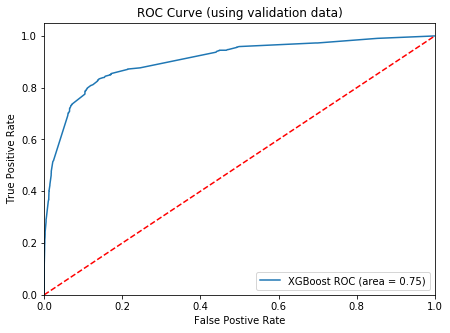

In [18]:
models = [{'label': 'XGBoost','model': model}]

plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

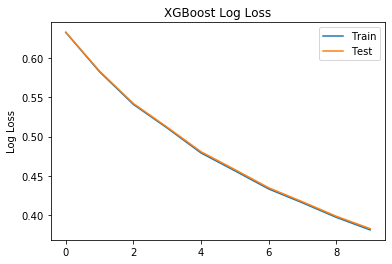

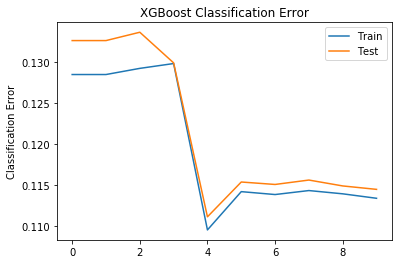

In [19]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


## Machine Learning Engineering

### Create ML pipeline

In [20]:
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

xgb_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=10,
                        learning_rate = 0.1))

])

## Test fit and predict

In [21]:
Prod_X_train, Prod_X_test, Prod_y_train, Prod_y_test = model_selection.train_test_split(df[df.columns.difference(target)], 
                                                                    df[target], 
                                                                    test_size=0.33, random_state=27513)

In [22]:
xgb_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=xgb_pipeline.predict(Prod_X_test)
Prod_y_predict

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 0, 0, 0])

In [23]:
xgb_pipeline.score(Prod_X_test, Prod_y_test)

0.8908960401961957

# Model Deployment

For Model Deployment purpose, we need some files:

    0. requirement.txt    
    1. score.py
    2. model.pickle
    3. dmcas_fitstat.json
    4. inputVar.json
    5. outputVar.json
    6. fileMetadata.json
    7. ModelProperties.json


In [47]:
! mkdir xgboost

mkdir: cannot create directory ‘xgboost’: File exists
/home/jovyan/work


## 1. requirement.txt

In [48]:
! pip freeze > ./xgboost/requirement.txt

## 2. Score.py 

## 3. model.pkl

In [28]:
from sklearn.externals import joblib
joblib.dump(xgb_pipeline, './xgboost/xgb_pipeline.pkl')

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['./xgboost/xgb_pipeline.pkl']

In [24]:
from utils import modelmanager_service

## 4. inputVar

In [25]:
modelmanager_service.generate_inputvar(abt, 'BAD', './xgboost', debug=False)

'inputVar.json file generated successfully!'

## 5. outputVar and targetVar

In [26]:
modelmanager_service.generate_outputvar(abt, 'BAD', './xgboost')

'outputVar.json and targetVar files generated successfully!'